참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 6.4 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=e07b11da37f2d061bfe1ef51d3c4fa0b28ad444a221fd417855a01489e6eecbe
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1380k      0  0:00:01  0:00:01 --:--:-- 3706k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거해서 원본 데이터에 저장

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [8]:
# 중복 제거한 뒤 데이터 개수 확인
type(total_data['ratings']) # series
len(total_data)
total_data.size

599724

In [9]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

### 데이터 정제 및 전처리

In [10]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 힣 뒤에 작은 공백 있엉
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거 (하나라도 있으면 제거)

### 토큰화

In [11]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/2. KOREA UNIV./KUBIG/NLP/Week 3/복습과제/stopword.txt') as f:
    list_file = f.readlines() # 한 줄씩 읽어와

# list_file -> '않다\n', '되어다\n'... 이렇게 나와

stopwords_list = [] # 비어있는 list
for stopword in list_file: # 각 stopword에 대해서
  stopwords = re.sub('[\n]', '', stopword) # stopword에서 엔터를 발견하면 없애
  stopwords_list.append(stopwords) # 위에서 만든 list에 append

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs) # 일단 mecab에 넣은 결과(형태소 단위로 분리)를 tokenized에 저장
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list]) # stopwords가 아닌 item에 대해 item 그대로 저장

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [12]:
train_data['reviews'].apply(mecab.morphs)[:4]

132466    [바디, 버든, 줄이, 려고, 써, 보, 려고, 샀, 는데, 음용, 할, 수, 잇,...
188461    [시중, 에, 판매, 하, 는, 건, 새, 우랑, 다르, 게, 속살, 이, 고루, ...
124757                           [깔끔, 하, 니, 이쁘, 네요, 좋, 습니다]
50357               [사이즈, 미스, !, 남자, 가, 쓰, 기, 엔, 너무, 작, 네요]
Name: reviews, dtype: object

### 정수 인코딩

In [13]:
train_data[:4]

,ratings,reviews,label,tokenized
132466,1,바디버든 줄이려고 써보려고 샀는데 음용할수잇는 물로 헹궈야되면 왜 식기세척기 쓰나요?,0,"[바디, 버든, 줄이, 려고, 써, 보, 려고, 샀, 는데, 음용, 할, 수, 잇,..."
188461,2,시중에 판매하는 건새우랑 다르게 속살이 고루분포된게아니라 속이비어보이고 속살이 한쪽...,0,"[시중, 판매, 는, 건, 새, 우랑, 다르, 게, 속살, 고루, 분포, 된, 게,..."
124757,4,깔끔하니 이쁘네요 좋습니다,1,"[깔끔, 니, 이쁘, 네요, 좋]"
50357,2,사이즈미스! 남자가 쓰기엔 너무작네요,0,"[사이즈, 미스, !, 남자, 쓰, 기, 엔, 너무, 작, 네요]"


In [14]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values # values(형태소들)만 가지고 와 (array로)
y_train = train_data['label'].values # 긍정/부정 표시한 것들만 가지고 와 (array로)
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [15]:
type(X_train)

numpy.ndarray

In [16]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 결과 : X_train에 있는 형태소들이 빈도에 따라 배열된

In [17]:
tokenizer.word_index # 각 형태소에 인덱스를 부여, 이를 정리한 dict -> 형태소를 숫자로 변환할 때 사용
tokenizer.word_counts # 각 형태소가 등장한 빈도를 정리한 dict -> 빈도를 알아보고자할 때 사용

tokenizer_view = pd.DataFrame({'index' : list(tokenizer.word_index.values()),
                               'words' : list(tokenizer.word_index.keys()),
                               'num' : list(tokenizer.word_counts.values())})
tokenizer_view.head()

,index,words,num
0,1,.,115
1,2,고,1
2,3,네요,59
3,4,도,2706
4,5,좋,3219


In [18]:
# 빈도수가 가장 많은 상위 7개 단어
tokenizer_view.sort_values(by = 'num', ascending = False).head()

,index,words,num
74,75,?,120397
36,37,사용,88895
49,50,서,55356
160,161,대비,54440
53,54,만족,52524


In [19]:
# vocab_size 설정
vocab_size = len(tokenizer.word_index) # 전체 개수

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') # 전체 데이터 중에서 빈도 수 기준으로 vocab_size 만큼의 단어를 가지고 와서 tokenizer에 넣을 것! 그 외의 단어들은 'OOV'로 대체
tokenizer.fit_on_texts(X_train) # X_train에 tokenizer 적용 -> tokenizer 틀 만듦
X_train = tokenizer.texts_to_sequences(X_train) # X_train의 형태소들을 tokenizer에 넣어서 숫자로 바꾸고 sequence로 출력
X_test = tokenizer.texts_to_sequences(X_test) # X_train으로 만든 tokenizer를 X_test에도 적용

In [20]:
# 근데 vocab_size를 전체 개수로 설정했으면.. oov_token이 나올 일이 없는 거 아닌가......?
oov_index = tokenizer.word_index.get('OOV') # 'OOV'의 인덱스 추출
oov_index # 1

oov_in_train = any(oov_index in seq for seq in X_train) # 'OOV'의 인덱스가 등장하는 문장이 있나요?
oov_in_train # True .. 왜 있지?

for seq in X_train:
  if oov_index in seq:
    print(seq)
  else:
    pass

# 멋있게 적으면
samples_with_oov = [seq for seq in X_train if oov_index in seq] # seq에 oov_index가 포함되어 있다면 그 seq를 출력해줘

# 엄.... 왜 있는거지

[150, 207, 139, 88, 140, 377, 346, 368, 1082, 165, 80, 1647, 1100, 43368, 368, 1, 7, 97, 5, 608, 173, 368, 1064, 221, 1100, 9732, 731, 3, 5278, 2756, 1613, 3, 2, 36, 1078, 295, 3, 7, 121, 8, 2, 2]
[48, 350, 261, 261, 261, 261, 461, 461, 461, 461, 48, 350, 261, 261, 261, 261, 461, 461, 461, 461, 670, 670, 670, 670, 179, 179, 1, 572, 572, 572, 572, 296, 296, 296, 296, 104, 104, 296, 296, 296, 296, 261, 261, 261, 261, 328, 328, 328, 328, 461, 461, 461, 461]


### 패딩




In [21]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train)) # map : X_train의 각 객체에 대해 len 적용

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154021234821105


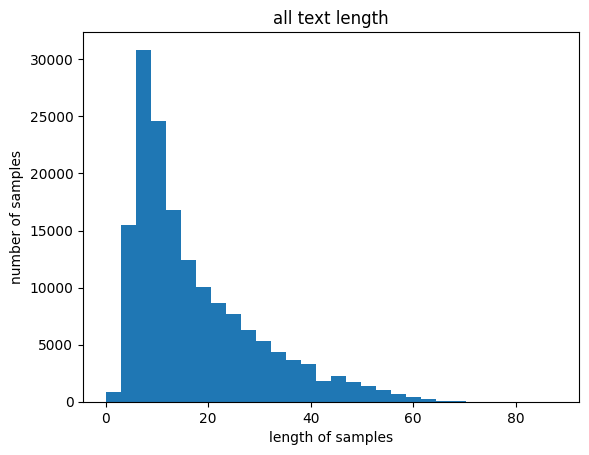

In [22]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [24]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len) # 리뷰 길이가 40개가 되도록 조정 -> 부족하면 패딩으로 채우고 남으면 잘라버려
X_test = pad_sequences(X_test, maxlen=max_len)
X_train.shape # (159926, 40)

(159926, 40)

In [25]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)
  # model.lower -> 입력을 RNN으로 해도 rnn을 잘 가져올 수 있어
  # models.get -> models에서 그 해당하는 모델을 가져와
  # (**model_params) -> 입력받은 model_params의 내용을 모델에 직접 할당해줘

### DataLoader 생성

In [26]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [27]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [28]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim) # vocab_size = 40 (아까 리뷰 길이) 길이 40의 벡터를 받아서 각 단어별로 길이 64의 벡터로 반환 -> (40,64)의 행렬로 나와

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim) # embedding_dim을 output_dim으로 바꿔줘

    def forward(self, text):
        embedded = self.embedding(text) # text를 받아 embedded로 임베딩 진행

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_() # 맨 처음 hidden state 초기화
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach()) # 최종 h0가 담겨 있음

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [29]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [30]:
iter = 0 # 변수 초기화
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader): # enumerate를 이용해 index를 i로 넣고, 나머지 부분으로 (text, labels)를 형성
        model.train()

        text = text.to(device)
        labels = labels.to(device) # train 진행한 애들 지금 쓰는 device로 불러와

        optimizer.zero_grad() # optimize 진행 전에 기울기 초기화

        logits = model(text).to(device) # text를 model에 넣어서 지금 쓰는 device로 불러와



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels) # 예측값 logit이랑 실제 값 label 이용해서 loss 계산

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step() # 가중치 업데이트해주세용

        iter += 1

        if iter % 500 == 0: # 500번의 반복마다
            model.eval() # evaluate 진행
            # Calculate Accuracy
            correct = 0 # 초기화 1
            total = 0 # 초기화 2
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text) # test set도 model에 넣어

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                  ## outputs.data의 출력값 중 1번째 차원에 대해 최댓값을 구해서 _에 최댓값을 저장 (실제로 사용하지 않아서 이렇게 간단히만 표현한대)
                  ## predicted로 최댓값 index 가져와 (class들 중에서 더 확률이 높게 책정된 것 - 아마도 0, 1이겠지?)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum() # 맞게 예측한 애들을 골라와

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Loss = []

Loss.append(f'Final Loss of RNN : {loss.item()}, Final Accurary of RNN : {accuracy}')

Iteration: 500. Loss: 0.4522782564163208. Accuracy: 86.02371215820312
Iteration: 1000. Loss: 0.3249592185020447. Accuracy: 87.94707489013672
Iteration: 1500. Loss: 0.13821104168891907. Accuracy: 88.54234313964844
Iteration: 2000. Loss: 0.2263224869966507. Accuracy: 88.92752075195312
Iteration: 2500. Loss: 0.17358803749084473. Accuracy: 89.89044952392578
Iteration: 3000. Loss: 0.34724265336990356. Accuracy: 88.91751098632812
Iteration: 3500. Loss: 0.25062596797943115. Accuracy: 89.77790069580078
Iteration: 4000. Loss: 0.18834583461284637. Accuracy: 87.474365234375
Iteration: 4500. Loss: 0.4685715138912201. Accuracy: 84.21289825439453
Iteration: 5000. Loss: 0.4329884350299835. Accuracy: 86.28382873535156
Iteration: 5500. Loss: 0.21354803442955017. Accuracy: 87.64944458007812
Iteration: 6000. Loss: 0.2558393180370331. Accuracy: 87.68445587158203
Iteration: 6500. Loss: 0.46144306659698486. Accuracy: 88.13966369628906
Iteration: 7000. Loss: 0.25087904930114746. Accuracy: 89.16512298583984
I

### 모델학습 (LSTM, Long short term memory)

In [31]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [32]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [33]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Loss.append(f'Final Loss of LSTM : {loss.item()}, Final Accurary of LSTM : {accuracy}')

Iteration: 1000. Loss: 0.3366287648677826. Accuracy: 90.27312469482422
Iteration: 2000. Loss: 0.1862325370311737. Accuracy: 91.34110260009766
Iteration: 3000. Loss: 0.15948936343193054. Accuracy: 91.3761215209961
Iteration: 4000. Loss: 0.11733444035053253. Accuracy: 91.78880310058594
Iteration: 5000. Loss: 0.07010406255722046. Accuracy: 91.6112289428711
Iteration: 6000. Loss: 0.23777741193771362. Accuracy: 91.48117065429688
Iteration: 7000. Loss: 0.22143515944480896. Accuracy: 91.61872863769531
Iteration: 8000. Loss: 0.18942703306674957. Accuracy: 91.51618194580078
Iteration: 9000. Loss: 0.06536217778921127. Accuracy: 91.36111450195312
Iteration: 10000. Loss: 0.04881840944290161. Accuracy: 91.45115661621094
Iteration: 11000. Loss: 0.1458221971988678. Accuracy: 91.12850952148438
Iteration: 12000. Loss: 0.1240747794508934. Accuracy: 91.19603729248047
Iteration: 13000. Loss: 0.13766217231750488. Accuracy: 90.96843719482422
Iteration: 14000. Loss: 0.02463291771709919. Accuracy: 91.14101409

### 모델 학습 (Gated Recurrent Unit (GRU))

In [34]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [35]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [36]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
Loss.append(f'Final Loss of GRU : {loss.item()}, Final Accurary of GRU : {accuracy}')

Iteration: 1000. Loss: 0.190071240067482. Accuracy: 90.7883529663086
Iteration: 2000. Loss: 0.303018718957901. Accuracy: 91.58121490478516
Iteration: 3000. Loss: 0.21962161362171173. Accuracy: 91.70376586914062
Iteration: 4000. Loss: 0.17071810364723206. Accuracy: 91.9263687133789
Iteration: 5000. Loss: 0.13958969712257385. Accuracy: 91.54369354248047
Iteration: 6000. Loss: 0.24413272738456726. Accuracy: 91.7237777709961
Iteration: 7000. Loss: 0.05989338457584381. Accuracy: 91.67875671386719
Iteration: 8000. Loss: 0.21781650185585022. Accuracy: 91.44114685058594
Iteration: 9000. Loss: 0.12751361727714539. Accuracy: 91.2535629272461
Iteration: 10000. Loss: 0.1561218500137329. Accuracy: 91.16352081298828
Iteration: 11000. Loss: 0.10711769759654999. Accuracy: 90.90090942382812
Iteration: 12000. Loss: 0.24735207855701447. Accuracy: 91.18853759765625
Iteration: 13000. Loss: 0.12787339091300964. Accuracy: 90.87089538574219
Iteration: 14000. Loss: 0.049788713455200195. Accuracy: 90.8908996582

## 모델 성능 비교

In [37]:
Loss

['Final Loss of RNN : 0.2849785387516022, Final Accurary of RNN : 88.39727783203125',
 'Final Loss of LSTM : 0.06390877068042755, Final Accurary of LSTM : 89.9479751586914',
 'Final Loss of GRU : 0.1575641632080078, Final Accurary of GRU : 89.53279113769531']

Vanilla RNN 의 Accuracy는 학습과정에서 주로 88~89% 정도를 기록하는 반면, LSTM과 GRU의 경우 90%이나 그 이상의 Accuracy를 보임을 알 수 있다.

학습이 마무리되어 최적화가 진행된 상황에서, 세 모델은 차례대로 90.3%, 90.1%, 90%의 Accuracy를 보인다.

전반적으로 큰 차이는 아니지만, 최적화 과정에서는 Vanilla RNN에 비해 LSTM과 GRU의 성능이 약간 뛰어났으나 최적화 후에는 세 모델이 비슷해졌음을 알 수 있다.  

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

In [38]:
# RNN
model_rnn = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_rnn = model_rnn.to(device)
optimizer_rnn_1 = torch.optim.Adam(model_rnn.parameters(), lr = 0.01)
optimizer_rnn_2 = torch.optim.SGD(model_rnn.parameters(), lr=0.05)

# LSTM
model_lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_lstm = model_lstm.to(device)
optimizer_lstm_1 = torch.optim.Adam(model_lstm.parameters(), lr = 0.01)
optimizer_lstm_2 = torch.optim.SGD(model_lstm.parameters(), lr=0.05)


# GRU
model_gru = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model_gru = model_gru.to(device)
optimizer_gru_1 = torch.optim.Adam(model_gru.parameters(), lr = 0.01)
optimizer_gru_2 = torch.optim.SGD(model_gru.parameters(), lr=0.05)

criterion = nn.CrossEntropyLoss()

models = [model_rnn, model_rnn, model_lstm, model_lstm, model_gru, model_gru]
optimizers = [optimizer_rnn_1, optimizer_rnn_2, optimizer_lstm_1, optimizer_lstm_2, optimizer_gru_1, optimizer_gru_2]

In [39]:
max_iter = 15000
def training(model, optimizer):
  iter = 0
  for epoch in range(num_epoch):
      # 시간 절약을 위해 최대 iteration 수를 조정
      if iter >= max_iter:
        break

      for i, (text, labels) in enumerate(train_dataloader):
          model.train()

          text = text.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          logits = model(text).to(device)
          # Calculate Loss: softmax --> cross entropy loss
          loss = criterion(logits, labels)
          loss.backward()

          # Updating parameters
          optimizer.step()

          iter += 1

          if iter % 1000 == 0:
              model.eval()
              # Calculate Accuracy
              correct = 0
              total = 0
              # Iterate through test dataset
              for test_text, test_labels in test_dataloader:
                  test_text = test_text.to(device)
                  test_labels = test_labels.to(device)
                  # Forward pass only to get logits/output
                  outputs = model(test_text)

                  # Get predictions from the maximum value
                  _, predicted = torch.max(outputs.data, 1)

                  # Total number of labels
                  total += test_labels.size(0)

                  # Total correct predictions
                  correct += (predicted == test_labels).sum()

              accuracy = 100 * correct / total

              # Print Loss
              print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

  Loss.append(f'Final Loss : {loss.item()}, Final Accurary : {accuracy}')

In [40]:
for i in range(6):
  model = models[i]
  optimizer = optimizers[i]
  training(model,optimizer)

Iteration: 1000. Loss: 0.5665430426597595. Accuracy: 72.05742645263672
Iteration: 2000. Loss: 0.18126602470874786. Accuracy: 88.70491790771484
Iteration: 3000. Loss: 0.37494751811027527. Accuracy: 88.41979217529297
Iteration: 4000. Loss: 0.18111276626586914. Accuracy: 87.3568115234375
Iteration: 5000. Loss: 0.1694168895483017. Accuracy: 86.91410827636719
Iteration: 6000. Loss: 0.381076842546463. Accuracy: 87.4243392944336
Iteration: 7000. Loss: 0.2853793501853943. Accuracy: 86.8515853881836
Iteration: 8000. Loss: 0.31271862983703613. Accuracy: 87.74698638916016
Iteration: 9000. Loss: 0.3566600978374481. Accuracy: 83.90525817871094
Iteration: 10000. Loss: 0.3348688781261444. Accuracy: 86.2738265991211
Iteration: 11000. Loss: 0.242778018116951. Accuracy: 86.60897827148438
Iteration: 12000. Loss: 0.2950848340988159. Accuracy: 86.9641342163086
Iteration: 13000. Loss: 0.5134509801864624. Accuracy: 86.14376831054688
Iteration: 14000. Loss: 0.3818679451942444. Accuracy: 86.43389892578125
Iter

In [41]:
Loss

['Final Loss of RNN : 0.2849785387516022, Final Accurary of RNN : 88.39727783203125',
 'Final Loss of LSTM : 0.06390877068042755, Final Accurary of LSTM : 89.9479751586914',
 'Final Loss of GRU : 0.1575641632080078, Final Accurary of GRU : 89.53279113769531',
 'Final Loss : 0.5243945121765137, Final Accurary : 85.1983413696289',
 'Final Loss : 0.32005423307418823, Final Accurary : 79.84092712402344',
 'Final Loss : 0.17446553707122803, Final Accurary : 90.87589263916016',
 'Final Loss : 0.19957317411899567, Final Accurary : 90.95843505859375',
 'Final Loss : 0.3506954610347748, Final Accurary : 85.43594360351562',
 'Final Loss : 0.42770975828170776, Final Accurary : 80.7413330078125']

In [47]:
loss = []
accuracy = []

for i in Loss:
    numbers = re.findall(r'\d+\.\d+', i) # \d+: 여러 숫자, \.: 소수점 -> 숫자.숫자 의 형태를 찾아줘
    loss.append(round(float(numbers[0]),2)) # str(문자) -> float(실수)로 변경해줘야 소수점 반영할 수 있어
    accuracy.append(round(float(numbers[1]),2))


model_names = ['RNN', 'LSTM', 'GRU']
models = pd.DataFrame({'model' : [name for name in model_names for i in range(3)],
                       'optimizer' : ['Adam', 'Adam', 'SGD', 'Adam', 'Adam', 'SGD', 'Adam', 'Adam', 'SGD'],
                       'lr' : [0.05, 0.01, 0.05, 0.05, 0.01, 0.05, 0.05, 0.01, 0.05],
                       'Loss' : loss,
                       'Accuracy' : accuracy})

models

,model,optimizer,lr,Loss,Accuracy
0,RNN,Adam,0.05,0.28,88.40
1,RNN,Adam,0.01,0.06,89.95
2,RNN,SGD,0.05,0.16,89.53
3,LSTM,Adam,0.05,0.52,85.20
4,LSTM,Adam,0.01,0.32,79.84
5,LSTM,SGD,0.05,0.17,90.88
6,GRU,Adam,0.05,0.20,90.96
7,GRU,Adam,0.01,0.35,85.44
8,GRU,SGD,0.05,0.43,80.74


실험해본 9가지 모델의 Accuracy와 Loss를 나타낸 표이다.

아쉽게도 특정 optimizer의 성능이 다른 것보다 더 좋다! 아니면, lr을 작게/크게 하는 것이 성능이 더 좋다! 하는 결론은 낼 수 없을 것 같다. RNN, LSTM, GRU 세 모형의 일반적인 성능을 비교하는 데에도 어려움이 있다.

현재 데이터를 이용했을 때는 GRU 모델을 사용하고 optimizer로는 Adam, lr은 0.05로 설정한 7번째 경우가 90.96의 Accuracy로 가장 좋은 성능을 보였다고 할 수 있겠다. 다만, Loss의 관점에서는 7번째 모델보다 더 좋은 모델이 몇 개 보이기 때문에, 어떠한 관점에서 모델을 선택할 것인지가 모델 결정에서 중요한 포인트가 될 것으로 보인다.

두 가지를 함께 고려했을 때에는 두 번째 모델인 RNN, Adam, lr=0.01의 조합이 가장 우수하다고 할 수 있겠다. 압도적으로 작은 Loss를 가졌음에도 나쁘지 않은 Accuracy를 보이는 것으로 보아, Overfitting의 경우는 아니라고 생각된다.


